## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
from sklearn import preprocessing

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
        x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(x)
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [76]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [77]:
# int(0.125*100+0.5)/100
# int(0.115*100+0.5)/100
# round 4捨五入 準確版

In [78]:
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def on_train_begin(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        x_test = self.validation_data[0]
        y_test = self.validation_data[1]      
        y_pred = np.round((self.model.predict(x_test)*100+0.5)/100)


        #validation_data=(x_test,y_test) from next section
        #validation_data[1]=y_test
        #argmax == Returns the indices of the maximum values along an axis.
        logs["val_tp"] = np.sum(np.logical_and(y_pred == 1, y_test == 1))
        logs["val_tn"] = np.sum(np.logical_and(y_pred == 0, y_test == 0))
        
        

        
rec_tptn = Record_tp_tn()

In [79]:
'''    
how np.argmax works

   [[ 0  3  8 13] 
    [12 11  2 11] 
    [ 5 13  8  3] 
    [12 15  3  4]] 
      ^  ^  ^  ^ 
     12 15  8  13  - element 
     1  3   0  0   - indices (row number)
'''


'    \n   [[ 0  3  8 13] \n    [12 11  2 11] \n    [ 5 13  8  3] \n    [12 15  3  4]] \n      ^  ^  ^  ^ \n     12 15  8  13  - element \n     1  3   0  0   - indices (row number)\n'

In [80]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_27 (Batc (None, 256)               1024

50000/50000 [==============================] - 7s 133us/step - loss: 0.5660 - accuracy: 0.8374 - val_loss: 1.6481 - val_accuracy: 0.4850
Epoch 47/50
50000/50000 [==============================] - 5s 107us/step - loss: 0.5516 - accuracy: 0.8413 - val_loss: 1.6557 - val_accuracy: 0.4803
Epoch 48/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.5354 - accuracy: 0.8455 - val_loss: 1.6696 - val_accuracy: 0.4848
Epoch 49/50
50000/50000 [==============================] - 8s 166us/step - loss: 0.5183 - accuracy: 0.8545 - val_loss: 1.6822 - val_accuracy: 0.4785
Epoch 50/50
50000/50000 [==============================] - 6s 117us/step - loss: 0.5036 - accuracy: 0.8605 - val_loss: 1.6919 - val_accuracy: 0.4822


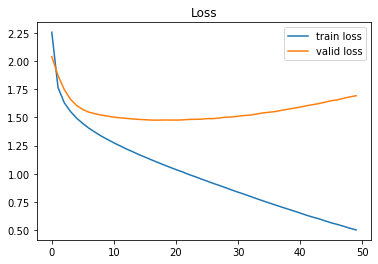

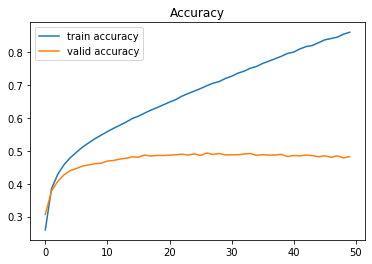

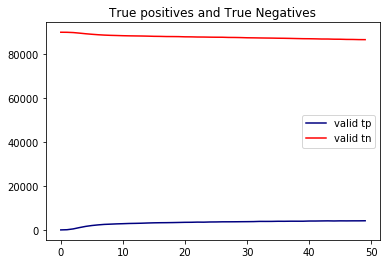

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
